<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">


# Week 7 - Text representations

This week'll focus on basic text representations using the **bag-of-words**-model (BoW). We will use this to, among other things perform **Latent semantic analysis** (LSA) using **Singular value decomposition** (SVD), and later, we'll do **sentiment analysis** of texts.


Many of the exercises may not seem all that difficult mathematically speaking, but are quite challenging from a code standpoint. As always, we encourage you to work with them, but not be afraid to skip exercises if they are too hard to code, or if you spend time purely on implementation work. **You will not be asked to write code for the exam.**. Even so, coding these exercises may be extremely useful for understanding the concepts that are behind this part of natural langauge processing.

---

**At the end of this week, you should be able to:**

- Understand what a bag-of-words representation is, and why it is important for how we process texts
- Explain some up- and downsides of the bag-of-words-representation
- Understand what the term-by-term and document-by-document matrices mean, and what their individual values mean.
- Understand how LSA is perforemed and what role SVD plays here
- Understand how LSA can be used to visualize similarities and/or differences in both documents and terms
- Understand what sentiment analysis is
- Understand what is required to perform sentiment analysis
- Understand how sentiment analysis is implemented


---

Creating a BoW representation of a corpus is fairly straightforward:

1. Find the number of unique words across all documents in the corpus
2. Initialize a zero-vector for each document in the corpus, its length should be equal to the number of unique words across all documents
3. For each document in the corpus, count the occurances of each unique word
4. Set these number of occurances in that document, as the value for the corresponding word in the corresponding vector
5. For $m$ documents and $n$ unique words, this should leave you with an $n \times m$ matrix we can call $A$. the number $a_{i,j}$ will then be how many times the i'th word appears in the j'th document
6. Optionally now, you can remove rows that correspond to stop words (this is often based on a known list of stop words)

This can then be expanded to include **bigrams**, **trigrams**, and in general, **n-grams**. This is simply done by increasing the number of unique words to include all unique bigrams, trigrams, etc. The result in any case, should be something akin to what we see below (though transposed in our case).

<img src="images/stuff.png"
        width = 400
        height = 300
        style="display: block; margin: 0 auto" />

---

LSA uses the BoW to attempt to analyze relationships between sets of documents and their words. It has one simple assumption:

<div style="text-align: center">
  <em>"Words that mean similar things, appear in similar contexts"</em>
</div>

In short, LSA can tell us two things in particular:

1. Documents that share a lot of words, must be closely related in subject
2. Words that appear in the same type of documents must be closely related in meaning

We perform LSA kinda like we do Principal Component Analysis (PCA), in this case, we use SVD. For the specific details of SVD, refer to the slides for week 7, page ~21.

For the purposes for implementation, we are interested in matrices in particular, which we get from our $n \times m$ BoW matrix $A$:

1. The term-by-term matrix, a $n \times n$ matrix, gotten from $B = AA^T$. $b_{i,j}$ tells us how many documents word $i$ appears in, that word $j$ also appears in
2. The document-by-document matrix, a $m \times m$ matrix, gotten from $C =A^TA$. $c_{i,j}$ tells us how many words are shared by document $i$ and document $j$

If we perform SVD on either of these matrices, we can get a lower-dimensional representation of how our documents or our words relate to one another. Letting us plot which words or documents relate to one another, very useful for large corpuses. Of course, there are a few limitations, among other things, we cannot say anything about words that do not appear in the corpus (outside our vocabulary). Nor can we say anything about the ordering of words, grammar, or the endings of words.

---

Sentiment analysis for a single document can be deceptively simple to implement:

1. For each word in the document, get the sentiment of that specific word (based on a known dictionary of sentiments)
2. Add this to a sum

That's it. It's also pretty simple mathematically: $S = \sum_{k=1}^K s_k$ where $s_k$ is simply the sentiment of the k'th word - as mentioned, we find this by a dictionary usually, or a 3'rd party model. 

To get the arousal score instead, how many "feelings" a document uses in total, we simply get the absolute sentiment of each word instead.


</span>

In [1]:
%matplotlib inline
import pylab as plt
import seaborn as snb
import numpy as np
import pandas as pd
import re

from tqdm import tqdm
from sklearn.metrics import confusion_matrix

from mpl_toolkits.axes_grid1 import make_axes_locatable
snb.set_style('darkgrid')

<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

## Part 1 - Bag of Words representation

Throughout these exercises, we'll work with the following corpus of 6 paper titles. This is of course, very much a toy example, but it shows the fundamentals well enough before we move unto more complicated datasets the follwing weeks.

</span>

In [5]:
# All our documents - In this case, we don't have any numbers or special characters, which makes preprocessing quite a bit easier...
documents = ['Analysis of EEG Signal for the Detection of Brain Abnormalities',
            'EEG source imaging assists decoding in a face recognition task',
            'Brain Source Localization Using EEG Signal Analysis',
            'Deep Neural Networks for Object Detection',
            'Imagenet classification with deep convolutional neural networks',
            'Very deep convolutional networks for large-scale image recognition']

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 0 - Basic string manipulation in Python

Python does tons of things in ways no other programming language would dream of doing them. For that reason, it's good enough to familiarize yourself with at least some of the basics.

Overall, familiarize yourself with the commands and methods, play around with them as you like, but don't get stuck too long here.

If you're already familiar with string manipulation in Python, feel free to skip this exercise.

#### **0.1 💻 Familiarize yourself with the following ways of manipulating strings in Python. Mess around with the results until you get a feel for what each one does.**

Assume all variables are python strings (`<class 'str'>`) unless otherwise specified

1. Concatenating two strings, `a` and `b` with `a + b`
2. Repeating a string `a` n times with `a * n`
3. Converting a string `a` to lower- or upper-case with `a.lower()` and `a.upper`, respectively
4. Finding out whether a substring `c` is contained within a given string `a` with `c in a` (yields true or false)
5. Splitting a string `a` based on a certain delimiter `d` with `a.split(d)` (default split value is on whitespace)
6. Joining a list of strings `e`, while adding a given delimiter `f` between each element with `f.join(e)` 
7. Use f-strings to format with. Adding a string `b` to a given string `a` being created with the pattern of `a = f"the value of b will be printed after the colon: {b}"`

Kinda uniquely, Python also lets you treat strings as 'lists of characters', so you can index and slice strings as you would normally

8. Index a string `a` to get the `n`'th (where n is an integer) letter with `a[n]`
9. Get a substring from `a` from the `n`'th to the `m`'th letter (`n` and `m` being integers): `a[n:m]`
10. Get the number of letters in a string `a` with `len(a)`

Finally, Python supports [Regular Expressions](https://en.wikipedia.org/wiki/Regular_expression). Essentially a supremely flexible way of matching strings or finding patterns in strings. Python does this through the `re` module, available by default in most Python compilers. re in Python uses '[patterns](https://docs.python.org/3/library/re.html)' to determine what is being matched on. These can be rather complicated, so our advice is, don't worry about learning them by heart. Look up specific usecases on stackexchange or make an LLM write them...

11.  Search for the **first match** on a specific pattern `p` in a string `a` with `re.search(p, a)`
12.  Return **all non-overlapping matches** for pattern `p` in a string `a` with `re.findall(p, a)`
13.  Split a string `a` on a specific pattern `p`p with `re.split(p, a)` - like a more flexible version of `.split()`
14.  Substitute a specific pattern `p` with a string `b`' in a string `a` with `re.sub(p, b, a)`


There are obviously tons more, but for something like string manipulation, it is often best to just look up solutions for a specific usecase when you need it.


</span>

In [ ]:
a = "Some"
b = "Body"

# 1 String concatenation
concatenated = a + b
print(concatenated)

# 2 String multiplication
multiplied = a * 5
print(multiplied)

# 3 Converting upper, lower
lowered = a.lower()
uppered = a.upper()
print(lowered, uppered)

# 4 Substring in String
some_in_body = a in b
some_in_somebody = a in (a + b)
print("is some in body:", some_in_body)
print("is some in somebody:", some_in_somebody)

# 5 Splitting on delimiter
text = """Somebody once told me the world is once gonna roll me.
I ain't the sharpest tool in the shed"""

split_by_whitespace = text.split()
print(split_by_whitespace)

split_by_newline = text.split("\n")
print(split_by_newline)

# 6 Joining with separator
separator = "" # blank separator
joined_text = separator.join(split_by_whitespace)
print(joined_text)

# 7 F strings
what_you_are = "all star"
what_am_i = f"Hey now! You're an {what_you_are}, get your game on, go play!"
print(what_am_i)

# 8 Indexing letters
first_letter = text[0]
last_letter = text[-1]
some_letter_in_middle = text[10]
print(first_letter, last_letter, some_letter_in_middle)

# 9 slicing text
first_four_letters = text[0:5] # here, you technically don't need to write 0, and you could have written it as text[:5]
print(first_four_letters)

# 10 number of letters
num_letters = len(text)
print(num_letters)

# 11 Finding the first match
pattern = "once"
first_match = re.search(pattern, text)
print(first_match)

# 12 Find all matches
pattern = "once"
first_match = re.findall(pattern, text)
print(first_match)

# Extra, find first and also every word that starts with a capital letter
pattern = r'\b[A-Z][a-z]*\b' # r-strings here are 'raw' strings, makes it easier to write \, otherwise Python woudl escape these
first_match = re.search(pattern, text)
all_matches = re.findall(pattern, text) 
print(first_match, all_matches)

# Extra, instead of finding it as a list, we can also find it as an iterable of all matches
iterable_all_matches = re.finditer(pattern, text)

# 13 Split on pattern
pattern = r'[^a-zA-Z0-9 ]+' # Matches on everything NOT a capital or lower letter from a-z, a number from 0-9, or a whitespace (notice the whitespace at the end of the square brackets)
split_by_special_character = re.split(pattern, text)
print(split_by_special_character)

# 14 Replace on pattern
pattern = r'[a-zA-Z0-9 ]+' # Matches on everything THAT IS capital or lower letter from a-z, a number from 0-9, or a whitespace (notice the whitespace at the end of the square brackets)
replace_text = "pickle"
replace_with_text = re.sub(pattern, replace_text, text)
print(replace_with_text)


<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 1 - Preprocessing and constructing the vocabulary

Here, we want to do a number of things

1. Get information on the amount of documents and words in the corpus
2. Create a vocabulary of all unique words in the corpus
3. Remove all non-informative words, I.E. stop words

After implementing each function, you can test them using the cell two times below.

#### **1.1 💻 Complete the function `get_corpus_info` below to get the number of words and documents in the corpus**

#### **1.2 💻 Complete the function `create_vocab` below to get the vocabulary**

#### **1.3 💻 Complete the function `remove_stop_words` to remove stop words from the vocabulary**

#### **1.4 Consider the current list of stop words; is it good enough? Are there too many or too few? What are the benefits/drawbacks of removing stop words?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>


</span>

In [25]:
def get_corpus_info(corpus):
    num_documents = len(corpus)
    words = []
    for i in range(len(corpus)):  
        doc = corpus[i]
        doc = doc.lower()
        doc = doc.replace(',', '').replace('.', '').replace(':', '').replace(';', '').replace('!', '').replace('?', '')
        words.extend(doc.split(' '))
    num_words = len(words)
    
    
    

    return num_documents, num_words, words

def create_vocab(all_words):
    """Create vocabulary based on all words in the corpus

    Args:
        all_words (list[str]): Unordered list of all words present in the corpus. Words must be lower-case 

    Returns:
        list[str]: List of all unique words present in the corpus
    """

    # TODO:
        # 1. Get all unique words in all_words
        # 2: Return these unique words (optionally sort them first)
    
    vocabulary = list(set(all_words))
    vocabulary.sort()

    return vocabulary

def remove_stop_words(vocabulary, stop_words):
    """Removes stop words present in a list from a given vocabulary

    Args:
        vocabulary (list[str]): List of all the words in the vocabulary
        stop_words (list[str]): List of all stop words to remove from vocabulary

    Returns:
        list[str]: Vocabulary with stop words removed
    """
    
    # TODO:
        # 1. For each word in vocabulary, remove that word if it is contained in stop words
    updated_vocabulary = []
    for word in vocabulary:
        if word not in stop_words:
            updated_vocabulary.append(word)

    return updated_vocabulary

## Test

In [26]:
# lower-case documements
documents = [doc.lower() for doc in documents]

num_docs, num_words, words = get_corpus_info(documents)

print(f"Number of documents:\t{num_docs}")
print(f"Number of words:\t{num_docs}")

vocabulary = create_vocab(words)
print(f"Vocabulary size:\t{len(vocabulary)}")
print(f"All words in vocabulary: {vocabulary}")

# create list of stop words
stop_words = ['the', 'of', 'in', 'via', 'for', 'a', 'with', 'to', 'and', 'very', 'using']
print(f"Number of stop words:\t{len(stop_words)}")

# Remove stop words from vocabulary
vocabulary = remove_stop_words(vocabulary, stop_words)
print(f"Number of words in vocabulary after removing stop words:\t{len(vocabulary)}")


Number of documents:	6
Number of words:	6
Vocabulary size:	31
All words in vocabulary: ['a', 'abnormalities', 'analysis', 'assists', 'brain', 'classification', 'convolutional', 'decoding', 'deep', 'detection', 'eeg', 'face', 'for', 'image', 'imagenet', 'imaging', 'in', 'large-scale', 'localization', 'networks', 'neural', 'object', 'of', 'recognition', 'signal', 'source', 'task', 'the', 'using', 'very', 'with']
Number of stop words:	11
Number of words in vocabulary after removing stop words:	23


<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 2 - **Constructing the bag-of-words representation**

We are now ready to construct the bag-of-words representation for our small text corpus. The bag-of-words model is a matrix representation of a text corpus describes how many times a given word is present in a given document. Specifically, the bag-of-words matrix is a matrix $\mathbf{A}$, where the number of rows is equal to the number of words in the vocabulary and the number of columns is equal to the number of documents, i.e. $\mathbf{A} \in \mathbb{R}^{\text{Voculary size} \times \text{Number of documents}}$ . The element in the i'th row and j'th column describes how many times the i'th word in the vocabulary occurs in the j'th document

$$A_{ij} = \text{Number of times the i'th word in the vocabulary occurs in the j'th document}.$$

It is common that each document only contains a small subset of the vocabulary words, and therefore the bag-of-words matrices are most often **sparse**, meaning that each column contains mostly zeros.


The words in the vocabulary is sometimes also referred to as *terms* and the bag-of-words matrix is also referred to as the **term-by-document matrix**.

#### **2.1 Inspect the function `construct_bag_of_words` that implements the function for constructing a bag-of-words representation based on a corpus of documents and its associated vocabulary. In broad strokes, how does the function work?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

It creates an empty matrix and fills it with integers ticking up each time at word in the doc is equal to the word in the vocabulary

</span>

#### **2.2 Inspect the output of the function by running the cell two steps below. Is there anything that stands out in this particular BoW?**


<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

It isnt square, meaning SVD is needed instead of PCA

</span>


</span>

In [27]:
def construct_bag_of_words(documents, vocabulary):
    '''
    This functions takes a list of documents and a vocabulary a returns the corresponding bag-of-words representation of the documents
    
    If the variable "document" is a list of N documents and the variable "vocabulary" is a list of M words, then the function should return a bag-of-words matrix A of size N x M matrix.
    If some word from a document is not present in the vocabulary, it should be ignored.
    '''
    
    num_doc = len(documents)
    vocab_size = len(vocabulary)
        
    # Make a word-to-idx mapping so each word can be mapped to a unique index
    word2idx = {word: idx for idx, word in enumerate(vocabulary)}
    
    # Create a matrix where rows are words and columns are documents
    bag_of_words = np.zeros((vocab_size, num_doc))
    
    # Enumerate over each document
    for idx_doc, doc in tqdm(enumerate(documents)):
        # And each word in document...
        for word in doc.split():
            if word in vocabulary:
                # ...increment the counter for that one word in a given document once (use word2idx to get a index based)
                bag_of_words[word2idx[word], idx_doc] += 1

    return bag_of_words
    

In [28]:
A = construct_bag_of_words(documents, vocabulary)       

# print bag of words matrix and along with the vocabulary
print(35*'-')
print('Bag of word matrix')
print(35*'-')

for vocab_word, A_row in zip(vocabulary, A):
    # The :<15 means we left-align the text with 15 characters width
    print(f"{vocab_word:<15} {A_row}")
    
# print documents
print('\n')
print(70*'-')
print('Documents')
print(70*'-')
for doc in documents:
    print(doc)

6it [00:00, 10267.57it/s]

-----------------------------------
Bag of word matrix
-----------------------------------
abnormalities   [1. 0. 0. 0. 0. 0.]
analysis        [1. 0. 1. 0. 0. 0.]
assists         [0. 1. 0. 0. 0. 0.]
brain           [1. 0. 1. 0. 0. 0.]
classification  [0. 0. 0. 0. 1. 0.]
convolutional   [0. 0. 0. 0. 1. 1.]
decoding        [0. 1. 0. 0. 0. 0.]
deep            [0. 0. 0. 1. 1. 1.]
detection       [1. 0. 0. 1. 0. 0.]
eeg             [1. 1. 1. 0. 0. 0.]
face            [0. 1. 0. 0. 0. 0.]
image           [0. 0. 0. 0. 0. 1.]
imagenet        [0. 0. 0. 0. 1. 0.]
imaging         [0. 1. 0. 0. 0. 0.]
large-scale     [0. 0. 0. 0. 0. 1.]
localization    [0. 0. 1. 0. 0. 0.]
networks        [0. 0. 0. 1. 1. 1.]
neural          [0. 0. 0. 1. 1. 0.]
object          [0. 0. 0. 1. 0. 0.]
recognition     [0. 1. 0. 0. 0. 1.]
signal          [1. 0. 1. 0. 0. 0.]
source          [0. 1. 1. 0. 0. 0.]
task            [0. 1. 0. 0. 0. 0.]


----------------------------------------------------------------------
Document

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 3 - Examining output from the BoW representation

Here, we consider two new "documents":

- "EEG Source localization assists face recognition"
- "Face recognition assists EEG Source localization"

And examine how they are represented in our BoW

#### **3.1 💻 Write code to create a BoW representation of these two new documents. Feel free to use functions and code you've written beforehand**

#### **3.2 Using this code, validate the bag-of-words matrix above by comparing it to the documents given here, does it make sense to use our BoW for these new documents? Why / Why not?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>


#### **3.3 How could you go about handling the case where a new document came with a word outside of our vocabulary?**


<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Ignore it. It wont have a row. Another option is expanding the vocabulary if an unknown word is found before also counting these

</span>

#### **3.4 Explain which semantic structures of the text documents are preserved and which structures are lost using the bag-of-words representation?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">


The words are kept but the order is lost. This can cause important information. It could be fine for assesing sentiment or arousal

</span>

</span>

In [ ]:
document_1 = "EEG Source localization assists face recognition"
document_2 = "Face recognition assists EEG Source localization"

# TODO:
    # 1. Use the construct_bag_of_words function with the new documents and existing vocabulary

# Create bag of words
A_1 =

for vocab_word, A_row in zip(vocabulary, A_1):
    # The :<15 means we left-align the text with 15 characters width
    print(f"{vocab_word:<15} {A_row}")

# print documents
print('\n')
print(70*'-')
print('Documents')
print(70*'-')
for doc in [document_1, document_2]:
    print(doc)




<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 4 - The term-by-term and document-by-document matrices

*We will now construct the so-called term-by-term matrix, $\mathbf{B} = \mathbf{A}\mathbf{A}^T$, and document-by-document matrix, $\mathbf{C}=\mathbf{A}^T\mathbf{A}$. The $\mathbf{B}$ matrix is sometimes also known as the **co-occurence matrix**.*


#### **4.1. Explain why these names are appropriate for the matrices $\mathbf{B}$ and $\mathbf{C}$**

*Hint: What does an inner product between two vectors represent?*

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Similarity

</span>

#### **4.2 Run the code in the cell below and inspect the plot of the matrix $\mathbf{A}$ to figure how many times the word "recognition" is present in the corpus.**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>

#### **4.3 What is the interpretation of the diagonal of the term-by-term matrix $\mathbf{B}$?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>

#### **4.4. Inspect the plot of the matrix $\mathbf{A}$ again to figure how many words the first document contains.**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>

#### **4.5 What is the interpretation of the diagonal of the document-by-document matrix $\mathbf{C}$?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>

#### **4.6. What does it mean of an off-diagonal element in $C_{n,m}$, $n \neq m$ is zero?**
*Hint: The (n,m)'th element of $\mathbf{C}$ can be written as: $C_{nm} = \sum_{k} A_{kn} A_{km}$ and $A_{kn}$ is zero if the k'th word is not present in the m'th document*

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>

</span>


</span>

Matplotlib is building the font cache; this may take a moment.


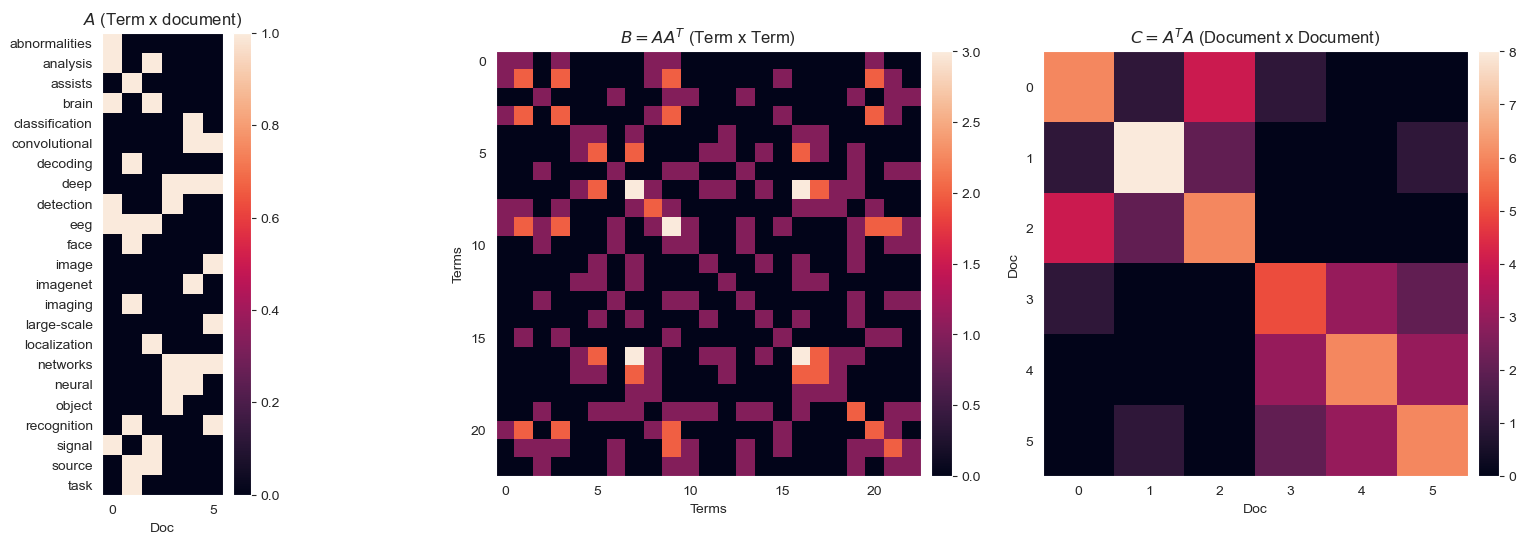

In [29]:
#compute the B and C matrix
B = np.matmul(A, A.T) # Also possible to use A @ A.T
C = np.matmul(A.T, A) # Also possible to use A.T @ A

plt.figure(figsize=(20, 6))
ax = plt.subplot(1, 3, 1)
im = plt.imshow(A)
plt.xlabel('Doc')
plt.yticks(np.arange(0, len(vocabulary)), vocabulary)
plt.title('$A$ (Term x document)')
plt.grid(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="15%", pad=0.1)
plt.colorbar(im, cax=cax)

ax = plt.subplot(1, 3, 2)
im = plt.imshow(B)
plt.xlabel('Terms')
plt.ylabel('Terms')
plt.title('$B = AA^T$ (Term x Term)')
plt.grid(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)

ax = plt.subplot(1, 3, 3)
im = plt.imshow(C)
plt.xlabel('Doc')
plt.ylabel('Doc')
plt.title('$C = A^T A$ (Document x Document)')
plt.grid(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)

plt.show()

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 5: Another interpretation of the matrices $B$ and $C$

If we consider each document as a separate observation, then the matrix $\mathbf{B}$ can be interpreted as the second moments of the documents and hence, the matrix $\mathbf{B}$ is closely related to the empirical covariance matrix $\mathbf{S}$ of the documents. This naturally suggests that we use principal component analysis (PCA) to understand the structure of the documents by decomposing the matrix $\mathbf{B}$ into eigenvectors and eigenvalues,

$\mathbf{B} = \mathbf{U}\Lambda  \mathbf{U}^\top$,

where $\mathbf{U}$ is a matrix of eigenvectors and $\Lambda$ is a diagonal matrix of eigenvalues.  Specifically, it is a basis matrix where each basis direction is a latent topic – you can think of each as a “theme” capturing a particular pattern of how terms co-occur across documents.

Using a similar line of reasoning, we can decompose $\mathbf{C}$ as follows

$\mathbf{C} = \mathbf{V}\Lambda  \mathbf{V}^\top$.

It can be shown that the two matrices $\mathbf{B}$ and $\mathbf{C}$ share the same eigenvalues, so we only need one common $\Lambda$ matrix.

From $\mathbf{B}\mathbf{x} = \lambda \mathbf{x}$ we can obtain $\mathbf{C}\mathbf{z} = \lambda \mathbf{z}$ by using the definitions of $\mathbf{B}$ and $\mathbf{C}$.
That is, $\lambda$ is an eigenvalue of $\mathbf{C}$ corresponding to the eigenvector $\mathbf{A}^T \mathbf{x}$.

*(Optional) Technical note: Formally, the term-by-term matrix $\mathbf{B}$ is the second order moment of the documents and not the covariance matrix as typically used in principal component analysis. We could obtain the actual empirical covariance matrix from by substracting the outer product of the mean vectors, i.e. $\mathbf{S} = \mathbf{B} - \mathbf{m}\mathbf{m}^T$, where $\mathbf{m}$ is the mean document vector. However, we choose not to do this for computational reasons. Namely, the matrix $\mathbf{B}$ is sparse, meaning that most of the entries are equal to zero. This has the benefit that we can represent it very efficiently in our computers. In contrast, the covariance matrix $\mathbf{S}$ will in general not be sparse and hence, it is requires more memory to store the matrix. This does not make a big difference for the small example we consider here, but this can be prohibitive costly for real-world large-scale applications.  The same line of reasoning applies to the matrix $\mathbf{C}$.*

#### **5.1. Run the code below and verify that the eigenvalues of the two matrices are indeed the same:**

#### **5.2. Seemingly, B has more eigenvalues than C, yet these are all 0, why is this the case?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>



</span>

In [30]:
def eigendecompose(X):
    ''' Return the eigendecomposition (E, V) of X s.t. eigenvalues are sorted descendingly '''
    lam, V = np.linalg.eigh(X)
    sort_idx = np.argsort(lam)[::-1]
    return lam[sort_idx], V[:, sort_idx]

lambdas_C, V = eigendecompose(C)
lambdas_B, U = eigendecompose(B)
# Pretty print with 4 decimal places
np.set_printoptions(precision=6, suppress=True)

# Print for lambdas_C
print("Eigenvalues of C:")
print(lambdas_C)
print("\n")

# Print for lambdas_B
print("Eigenvalues of B:")
print(lambdas_B)
print("\n")

# Print the difference between lambdas_C and the first 6 eigenvalues of B
print("Difference (lambdas_C - first 6 of lambdas_B):")
print(lambdas_C - lambdas_B[:len(lambdas_C)])

Eigenvalues of C:
[11.862584 10.636732  6.968732  3.380007  2.591737  1.560208]


Eigenvalues of B:
[11.862584 10.636732  6.968732  3.380007  2.591737  1.560208  0.
  0.        0.        0.        0.        0.        0.        0.
 -0.       -0.       -0.       -0.       -0.       -0.       -0.
 -0.       -0.      ]


Difference (lambdas_C - first 6 of lambdas_B):
[ 0. -0.  0.  0. -0. -0.]


<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 6: Latent semantic analysis - Document-by-document

Studying the latent spaces induced by the eigendecompositions above is known as **Latent Semantic Analysis (LSA)** or sometimes also known as **Latent Semantic Indexing (LSI)**. We will now project each document to the latent semantic space to analyze how the documents relate to each other. 

Recall that,

$\mathbf{A} = \mathbf{U}\Lambda^{\frac{1}{2}}  \mathbf{V}^T$

$\mathbf{B} = \mathbf{A}\mathbf{A}^\top = \mathbf{U}\Lambda^{\frac{1}{2}} \underbrace{\mathbf{V}^T    \mathbf{V}}_{\mathbb{I}_{M\times M}} \Lambda^{\frac{1}{2}} \mathbf{U}^\top = \mathbf{U}\Lambda \mathbf{U}^\top$

$\mathbf{C} = \mathbf{A}^\top\mathbf{A} = \mathbf{V}\Lambda^{\frac{1}{2}} \underbrace{\mathbf{U}^T    \mathbf{U}}_{\mathbb{I}_{N\times N}} \Lambda^{\frac{1}{2}} \mathbf{V}^\top = \mathbf{V}\Lambda \mathbf{V}^\top$

We can project each document in our corpus to the latent semantic space as follows

$\mathbf{z}_{\text{doc}} = \mathbf{\Lambda}_k^{-\frac12}\mathbf{U}_k^T \mathbf{A} = \mathbf{P}_k \mathbf{A}$

where $\mathbf{P}_k = \mathbf{\Lambda}_k^{-\frac12}\mathbf{U}_k^T $ acts as a projection matrix. 

$\mathbf{P}_k = \mathbf{\Lambda}_k^{-\frac12}\mathbf{U}_k^T$

For visualization purposes, we will focus on $k = 2$ dimensions for now.

#### **6.1. Inspect the code below and list roughly what it does in order**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>

#### **6.2. The figure produced, shows that the 6 documents form 2 clusters in the latent semantic space. Can you figure out what the papers in each cluster have in common?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>


</span>

In [ ]:
# let's focus on the first two components for visualization purposes
k = 2

# Eigenvectors of document-by-document
Uk = U[:, :k]

# Eigenvalues
Lk = lambdas_C[:k]

# Eigenvectors of term-by-term
Vk = V[:, :k]

# define projection matrix for the documents
P = np.diag(1./np.sqrt(Lk))@Uk.T

# project
z_doc = P@A

plt.figure(figsize=(25, 15))
ax = plt.subplot(1, 2, 1)
for idx, doc in enumerate(z_doc.T):
    plt.plot([0, doc[0]], [0, doc[1]], 'b--')
    circle = plt.Circle((doc[0], doc[1]), radius=0.015)
    ax.add_patch(circle)
    label = ax.annotate(idx, xy=(doc[0], doc[1]), fontsize=20, ha="center", va="center")

plt.xlabel('Latent Semantic dim 1')
plt.ylabel('Latent Semantic dim 2')
    
plt.subplot(1, 2, 2)
plt.axis('off')
for idx, doc in enumerate(documents):
    i = idx
    plt.text(0, 1 - i / len(vocabulary), 'Doc %d: %s' % (i, doc), color='b')
    
    

*The dashed lines help to emphasise the angles between the vectors, which will be relevant when we use the cosine similarity metric later.*

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 7: Latent semantic analysis - Word-by-word

We can also project each word in our vocabulary to a 2 dimensional latent semantic space as follows

$\mathbf{z}_{\text{word}} = \mathbf{A} \mathbf{V}_k  \mathbf{\Lambda}_k^{-\frac12} = \mathbf{A}  \mathbf{P}_k$

where $\mathbf{P}_k = \mathbf{V}_k  \mathbf{\Lambda}_k^{-\frac12}$ acts as a projection matrix. 

#### **7.1. Explain The clustering structure that emerges in the semantic space**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>

#### **7.2. Two words appear to be between the two clusters. Can you explain why?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>

</span>

In [ ]:
# define projection matrix for the words
P = Vk@np.diag(1./np.sqrt(Lk))

# project
z_word = A@P

plt.figure(figsize=(25, 15))

ax = plt.subplot(1, 2, 1)
for idx, term in enumerate(z_word):
    plt.plot([0, term[0]], [0, term[1]], 'r--')
    circle = plt.Circle((term[0], term[1]), radius=0.015, color='r')
    ax.add_patch(circle)
    label = ax.annotate(idx, xy=(term[0], term[1]), fontsize=20, ha="center", va="center")
    
plt.xlabel('Latent Semantic dim 1')
plt.ylabel('Latent Semantic dim 2')
    
ax = plt.subplot(1, 2, 2)
plt.axis('off')
for idx, term in enumerate(vocabulary):
    i = idx
    plt.text(0.85, 1 - i/len(vocabulary), 'Term %d: %s' % (i, term), color='r')
    

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 8: Document retrieval: Let's try to find all the documents that have to do with the word "image" using cosine similarity

So far we have seen how we can relate words and documents to each other by project them to the common latent semantic space. We will now make use of these properties in order to build a simple **document retrival** system to search for relevant documents.

We will use the following recipe for searching for documents:
1. First, we will define a query vector with containing the keywords (using words from the vocabulary)  that we want to use in our search.
2. Next, we construct a bag-of-words representation of this vector using the function we implemented above. 
3. We project the bag-of-words representation to the latent semantic space.
4. We loop through the documents in the corpus to find the document that are closets to our projected query vector.
5. Return a list of the best matching documents

In bullet 4 above, we need to find the "closest" documents. There are several ways to compare documents, but here we will use the *cosine similarity* metric:

$\text{cosine similarity} (\mathbf{x}, \mathbf{y}) = \frac{\mathbf{x}^T \mathbf{y}}{\|\mathbf{x}\|\, \| \mathbf{y} \|}$

#### **8.1. 💻 Implement the function `cos_sim` for the system described above, and explain what the rest of the code below does:** 

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>

#### **2. Explain why the third document is almost as relevant to the search query as the first two documents even though the third document does not contain the word "Image"?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>

</span>

In [ ]:
def cos_sim(x, y):
    """Given two vectors, get the cosine similarity of them

    Args:
        x np.ndarray: First vector to compare to second 
        y np.ndarray: Second vector to compare to first

    Returns:
        np.ndarray: Single dimensional numpy array containing the cosine similarity between x and y
    """
    # Return cosine similarity here
    return ...

In [ ]:
# define search query
query = ['image']
    
# construct bag of words presentation for query
q = construct_bag_of_words(query, vocabulary)

# compute projection matrix
P = np.diag(1./np.sqrt(Lk))@Uk.T

# project
q_proj = P@q

# make sure that q_proj has the right shape
assert q_proj.shape == (2, 1), "The shape of q_proj must be (2, 1)"

similarities = np.array([cos_sim(q_proj, doc.T) for doc in z_doc.T])

doc_sims = zip(documents, similarities)
sorted_docs = sorted(doc_sims, key= lambda x:x[1], reverse=True)

print('Sorted list of document related to:', query)
print(100*'-')
for rank, doc_sim in enumerate(sorted_docs):
    doc, sim = doc_sim
    print(f'{rank + 1}. {doc:<70} ({sim.item():.2f})')

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 9: Topics

Sometimes it is possible to interpret each of the semantic latent dimensions as topic. Below we will analyze which words from the vocabulary have the strongest connection to the latent dimensions

#### **9.1. The figure created from the code below shows the coefficient associated with each word for each topic. Which words are positively associated with topic 2 and which words are negatively associated with topic 2?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>

</span>

In [ ]:
plt.figure(figsize=(20, 6))
ax = plt.gca()
im = plt.imshow(Uk.T, cmap=plt.cm.RdBu_r)
plt.grid(False)
plt.title('Transpose of the matrix $\mathbf{U}_k$')
plt.xticks(np.arange(0, len(vocabulary)), vocabulary, rotation=90)
plt.yticks(np.arange(0, k), ['Topic %d' % (i+1) for i in range(k)])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)


term_per_topic =5
for i, topic in enumerate(Uk.T):
    
    terms_topic = zip(vocabulary, topic)
    sorted_terms = sorted(terms_topic, key= lambda x:x[1], reverse=True)[:term_per_topic]
    
    print("Topic %d (latent dimension %i)" % (i+1, i+1))
    for t in sorted_terms:
        print('%20s (%3.2f)' % t)
    print('\n')

<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

## Part 2: Solving odd-one-out

As an example, find the 'odd-one-out' from the the list of four words: 'ship', 'car', 'plane', and 'orange'. 

Clearly, 'orange' is the odd one out here. In this exercise we will use latent semantic analysis to build a system to solve these puzzles automatically. 

Specifically, we will analyse 8447 articles from the News York Times (available here: https://github.com/moorissa/nmf_nyt), learn a latent semantic space and use that space to the solve odd-one-out puzzles.

First, we will load the data. The vocabulary list and the bag-of-words matrix are already prepared for us.

**You don't need to get all of the below code, but give it a read and see if it makes sense**

</span>


In [ ]:
# Open the data which is essentially one big tokenized document set
with open('data/nyt_data.txt') as f:
    documents = f.readlines()
documents = [x.strip().strip('\n').strip("'") for x in documents] 

# Oben the vocabulary where the numbers correspond to what words are present in the documents
with open('data/nyt_vocab.dat') as f:
    vocabulary = f.readlines()
vocabulary = [x.strip().strip('\n').strip("'") for x in vocabulary] 

num_doc = 8447
vocab_size = 3012 
A = np.zeros([vocab_size,num_doc])

for col in range(len(documents)):
    for row in documents[col].split(','):
        A[int(row.split(':')[0])-1,col] = int(row.split(':')[1])

<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

**1. Construct the term-by-term matrix $\mathbf{B} = \mathbf{A}\mathbf{A}^T$ and document-by-document $\mathbf{C} = \mathbf{A}^T \mathbf{A}$ and decompose them to eigenvalues and eigenvectors.**

**Be patient, this might take up to a few minutes.**

</span>

In [ ]:
B = A@A.T
C = A.T@A

lambdas, U = eigendecompose(B)
print('Done decomposing B.')

lambdas, V = eigendecompose(C)
print('Done decomposing C.')

<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

**2. Select the first $k$ dimensions and project the words that the $k$-dimensional latent space**

</span>

In [ ]:
k = 20
Uk = U[:, :k]
Sk = lambdas[:k]
Vk = V[:, :k]

# define projection matrix for the words
P = Vk@np.diag(1./np.sqrt(Sk))

# project
z_word = A@P

Below is the list of odd-one-out puzzles that we want to solve using latent semantic analysis.

In [ ]:
list_of_puzzles = [
                    ['ship', 'car', 'plane', 'orange'],
                    ['man', 'car', 'woman', 'person'],
                    ['sky', 'cup', 'glass', 'bowl'],
                    ['black', 'shoe', 'blue', 'red'],
                    ['basketball', 'coffee', 'water', 'milk'],
                    ['telephone', 'computer', 'dog', 'radio'],
                    ['president', 'door', 'minister', 'secretary'],
                    ['soccer', 'basketball', 'tennis', 'rain'],
                    ['photography', 'image', 'painting', 'airplane']
                    ]

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 10: Odd-one-out - Solving odd-one-out puzzles using 8447 articles from the New York Times

The code below implements the odd-one-out solver.

#### **10.1. Study the function `find_odd_one_out` below and explain what it does.**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>


#### **10.2. Add some puzzles of your own to the above list. Can you create puzzles that 'tricks' the solver?**


<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>


#### **10.3. Experiment with the number of latent dimensions k. How many dimensions do we need to solve this odd-one-out puzzles?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>

</span>

In [ ]:
def find_odd_one_out(puzzle):
    ''' the function takes a list of 4 words and 
        1. constructs a bag-of-words representation for each word
        2. projects them to the latent semantic space
        3. identifies the odd-one-out using cosine similaries
        4. returns the odd word '''
    
    # check if all words are present in vocab
    for word in puzzle:
        if word not in vocabulary:
            print('Word "%s" not found in vocabulary' % word)
    
    # construct bag-of-words representation
    q = construct_bag_of_words(puzzle, vocabulary)
    
    # compute project matrix
    P = np.diag(1./np.sqrt(Sk))@Uk.T

    # project to semantic space
    semantic_vectors = P@q

    # for each vector compute average cosine similarities to the three other concepts
    avg_sim = []
    for i in range(len(semantic_vectors.T)):

        # compute cosine similarities between i and the remaining three vectors
        cos_similarities = [cos_sim(semantic_vectors[:, i], semantic_vectors[:, j]) for j in range(len(semantic_vectors.T)) if i != j]

        # compute average and store
        avg_sim.append(np.mean(cos_similarities))
        
    # return the concept with lowest average cosine similarity
    return puzzle[np.argmin(avg_sim)]

#use the find_odd_one_out function to solve the puzzles
for puzzle in list_of_puzzles:
    
    odd_one = find_odd_one_out(puzzle)
    
    print('Concepts:', ', '.join(puzzle))
    print('Odd-one-out: %s' % odd_one)
    print('\n')

<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

## Part 3: Sentiment analysis of Amazon reviews

In the last part of the exercise, we will use sentiment analysis to Amazon product reviews. 

**The data (~250MB) can be downloaded from here: https://www.kaggle.com/snap/amazon-fine-food-reviews**

The goal is to predict whether the author of the review likes or dislikes the product he or she is reviewing.

(You can see more details about the data here if you are interested: https://towardsdatascience.com/latent-semantic-analysis-sentiment-classification-with-python-5f657346f6a3)

</span>


In [ ]:
# Read the data first

df = pd.read_csv('data/Reviews.csv', usecols=['Text', 'Score'])

# Let's get rid of the neutral reviews
df.dropna(inplace=True)
df[df['Score'] != 3]

# .. and group negative reviews (rating = 1 or 2) together and group positive reviews (ratings = 4 or 5) together
df['Pos'] = np.where(df['Score'] > 3, 1, 0)

documents = df['Text'].tolist()
positives = df['Pos'].tolist()
num_doc = len(documents)

print(f"In total, we have {num_doc} product reviews. Each review has an associated score of either 0 or 1, where 0 means a negative review and 1 means a positive review")

<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

**We then proprocess the text data by converting all reviews to lower case and remove all punctuation (periods, commas, questionmarks and exclamation marks)**

</span>

In [ ]:
documents_cleaned = []
for doc in documents:
    
    # to lower
    doc_cleaned = doc.lower()
    
    # Potentially remove stop words, not really important...
    #doc_cleaned = ' '.join([word for word in doc_cleaned.split() if word not in stop_words])    

    # All of these replacements could technically be done with a single re.sub
    doc_cleaned = doc_cleaned.replace('.', '')
    doc_cleaned = doc_cleaned.replace(',', '')
    doc_cleaned = doc_cleaned.replace('?', '')
    doc_cleaned = doc_cleaned.replace('!', '')
    documents_cleaned.append(doc_cleaned)


<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 11: Sentiment analysis using lexicons

By 'lexicons', we mean pre-curated lists of words and their attached sentiment

Now we will load our sentiment lexicon. We will use Afinn created by Finn Nielsen (https://github.com/fnielsen/afinn)

</span>


In [ ]:
from afinn import Afinn
from collections import defaultdict
sent_lexicon = defaultdict(lambda: 0, Afinn()._dict)

In [ ]:
# Initially, lets look up the sentiment for a few words
list_of_words = ['amazing', 'accept', 'hate', 'dislike', 'appreciate', 'stupid',  'love', 'like', 'enjoy', 'best', 'bad', 'worst', 'outstanding', 'food', 'politics', 'movie']

for word in list_of_words:
    if word in sent_lexicon:
        print('%-15s%+3.2f' % (word, sent_lexicon[word]))
    else:
        print('Word "%s" not found' % word)


# And the number of words in the lexicon
print("Number of words in the lexicon:", len(sent_lexicon))

# And the range of the sentiment values
lexicon_values = sorted(set(list(sent_lexicon.values())))
print("The unique sentiment values are:", lexicon_values)
print(f"That is, each word in the sentiment lexicon is associated with a score between {min(lexicon_values)} and {max(lexicon_values)}")

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

#### **11.1 💻 Implement the function `get_review_sentiment` to get the sentiment of a single review. It may be worthwhile to also add the possibilty to print the individual sentiments of each word in the review**


#### **11.2 Consider some limitations of this approach to getting sentiments?**
*Hint: Can you think of an example, where a single word changes the whole meaning of the review that is not found by the sentiment analysis?*


<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">


Your answer here $\dots$

</span>


</span>


In [ ]:
def get_review_sentiment(review, v=True):
    """_summary_

    Args:
        review (str): single review to score based on sentiment analysis
        v (bool, optional): Verbose?: Whether to print extended information about the review. Defaults to True.

    Returns:
        float: Combined sentiment score of the whole review
    """
    if v:
        print(f"Review to score: {review}")
        print('Words           Sentiments')
        print(26*'-')
    
    sentiment = 0
    for word in review.lower().split():
        if v:
            print('%-15s %3.2f' % (word, sent_lexicon[word]))
        sentiment += sent_lexicon[word]
    
    return sentiment

sentiment = get_review_sentiment(documents_cleaned[0])

print(f"\nOverall sentiment: {sentiment:2.1f}")


<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 12 - Sentiment lexicon to vocabulary and sentiment vector

In order to use the tools we already have at our disposal, we can convert the sentiment lexicon into a sentiment vocabulary and a sentiment vectors. This will allow us to compute sentiments as inner products between the bag of words representation and the sentiment vector

Using the bag of words representation, we can instead compute sentiments using inner products

#### **12.1 💻 Implement the function `dot_product_sentiment` to get the sentiment of a single review (or list of reviews) by using the dot product between the review(s) BoW representation and a vector of sentiments**

#### **12.2 💻 Use this same function to get a vector of the sentiment of every review in the dataset**

#### **12.3 Explain some of the advantages of getting sentiments this way, as opposed to as before in a for loop**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>

#### **12.4 To get the sentiments of all reviews, we first construct a BoW for all the reviews, what do you think its shape is?**


<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>

</span>


In [ ]:
def create_sentiment_vocabulary(sent_lexicon):
    """_summary_

    Args:
        sent_lexicon (defaultdict[str: int]): defaultdict of words as keys and sentiments as values. Should return 0 in case of unknown word

    Returns:
        dict_keys: A dict_keys object of all words in the sentiment lexicon
        np.ndarray: A numpy vector where the i'th element corresponds to the sentiment of the i'th word in the sentiment vocabulary also returned
    """

    sentiment_vocabulary = sent_lexicon.keys()
    sentiment_vec = np.zeros((len(sentiment_vocabulary), 1))
    for idx, word in enumerate(sentiment_vocabulary):
        sentiment_vec[idx, 0] = sent_lexicon[word]

    return sentiment_vocabulary, sentiment_vec

def dot_product_sentiment(documents: list[str], sentiment_vocabulary, sentiment_vec):
    """Get the sentiment of a str by using the dot product of its BoW representation, a sentiment vocab, and a sentiment vector 

    Args:
        document (list[str]): documents to get the sentiment of
        sentiment_vocabulary (dict_keys): A dict_keys object of all words in the sentiment lexicon
        sentiment_vec (np.ndarray): A numpy vector where the i'th element corresponds to the sentiment of the i'th word in the sentiment vocabulary also returned

    Returns:
        np.ndarray: vector of sentiments where the i'th element corresponds to the sentiment of the i'th document in the input list
    """

    # TODO:
        # 1. Get BoW represenation of the given list of doucments and given sentiment focabulary
        # 2. Get the sentiments using this BoW represenntation and a given vector of sentiments of words

    return ...

In [ ]:
# Get the sentiment of a single document
chosen_document = documents_cleaned[0]

# The star on create_sentiment_vocabulary is a smart method of *unpacking* arguments in Python. You can look it up if you want
sentiment = dot_product_sentiment([chosen_document], *create_sentiment_vocabulary(sent_lexicon))

print("Sentiment of the single document:", sentiment)

# Get the sentiment of every document in the reviews
print("\nCalculating all sentiments, this may take a while...")

all_sentiments = dot_product_sentiment(documents_cleaned, *create_sentiment_vocabulary(sent_lexicon))


print("First 10 sentiments:\n", all_sentiments[:10])
print("Shape of all_sentiments, what do you think the dimensions mean?", all_sentiments.shape)

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 13 - Predicting sentiments

Finally, we ask the question: "Can we predict the thresholded score of the reviews using our calculated sentiments?"

To perform this exercise, remember a few cells above when we loaded the data, we did this:

```python
# .. and group negative reviews (rating = 1 or 2) together and group positive reviews (ratings = 4 or 5) together
df['Pos'] = np.where(df['Score'] > 3, 1, 0)

documents = df['Text'].tolist()
positives = df['Pos'].tolist()
```


#### **13.1 Inspect the confusion matrices below as well as the code that creates them. How should the four numbers above be interpreted?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>

</span>


In [ ]:
CM = confusion_matrix(all_sentiments.ravel() > 0, np.array(positives) > 0)
CM_normalized = CM / CM.sum()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Raw counts
snb.heatmap(CM, ax=axes[0], annot=True, cmap="Reds", fmt='d',
            xticklabels=['true negative', 'true positive'],
            yticklabels=['predicted negative', 'predicted positive'])
axes[0].set_title('Confusion Matrix (Counts)')

# Normalized
snb.heatmap(CM_normalized, ax=axes[1], annot=True, cmap="Reds", fmt='.5f',
            xticklabels=['true negative', 'true positive'],
            yticklabels=['predicted negative', 'predicted positive'])
axes[1].set_title('Empirical Confusion Matrix')

plt.tight_layout()
plt.show()